In [1]:
from catkit.gen.surface import SlabGenerator
from ase.build import bulk
from ase.visualize import view
from collections import Counter
from ase import Atom
from ase.io import read, write
import numpy as np
import matplotlib.pyplot as plt
from deepmd.infer import DeepPot
from deepmd.infer import calc_model_devi
import os
# from mp_api.client import MPRester
# api_key='VJu07llihiS1dRqq8MPm1OT4p86jWOlc'
from catkit.build import molecule
from catkit.gen.adsorption import Builder
import dpdata
import json
from sklearn.metrics import mean_squared_error
import itertools
import random
from catkit.gen.pathways import ReactionNetwork
from catkit.gen import molecules
from catkit.gen.adsorption import Builder
import networkx as nx
from ase.utils import formula_hill
from ase.db import connect
from ase.optimize import BFGS
from deepmd.calculator import DP
from itertools import combinations_with_replacement
from scipy.spatial.distance import cdist
from ase import Atoms
from scipy.spatial.distance import cdist
from ase.geometry import get_distances

/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/utils/connectivity.py:4: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.0)
  import scipy
2024-07-04 03:20:29.170323: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
react = {'C': [0], 'N': [1], 'H': [2, 3, 4, 6, 7], 'O': [5]}
prod_adjacency = {1: [0, 2, 3], 0: [1, 5, 4, 6], 5: [0, 7], 2: [1], 3: [1], 4: [0], 6: [0], 7: [5]}

# Extract 'H' indices from the react dictionary
H_indices = react['H']

# # Create a mapping from old 'H' indices to new ones
# new_index_map = {old_index: new_index for new_index, old_index in enumerate(H_indices)}

new_dict = {}
new_index_map = {}
H_counter = 0
for elem in sorted(prod_adjacency.keys()): # {1: [0, 2, 3], 0: [1, 5, 4, 6], 5: [0, 7], 2: [1], 3: [1], 4: [0], 6: [0], 7: [5]}
#     print(prod_adjacency[elem])
    for val in prod_adjacency[elem]:
        if val in H_indices:
            new_index_map[val] = H_indices[H_counter]
            H_counter += 1
print(new_index_map)
            
prod_new = {}
for elem in sorted(prod_adjacency.keys()):
    key = elem
    if elem in H_indices:
        key = new_index_map[elem]

    value = [x if x not in H_indices else new_index_map[x] for x in prod_adjacency[elem]]
    prod_new[key] = value
prod_new

{1: [0, 2, 3], 0: [1, 5, 4, 6], 5: [0, 7], 2: [1], 3: [1], 4: [0], 6: [0], 7: [5]}
{4: 2, 6: 3, 2: 4, 3: 6, 7: 7}
{key: value}
{0: [1, 5, 2, 3], 1: [0, 4, 6], 4:[1]}

# # Function to reindex adjacency list
# def reindex_adjacency_list(adjacency_list, index_map):
#     return [index_map.get(item, item) for item in adjacency_list]

# # Create the new prod_adjacency dictionary
# new_prod_adjacency = {}
# for key, value in prod_adjacency.items():
#     if key in H_indices:
#         new_key = new_index_map[key]
#     else:
#         new_key = key
#     new_value = reindex_adjacency_list(value, new_index_map)
#     new_prod_adjacency[new_key] = new_value

# # Sorting the adjacency lists
# for key in new_prod_adjacency:
#     new_prod_adjacency[key].sort()

# print(new_prod_adjacency)


{4: 2, 6: 3, 2: 4, 3: 6, 7: 7}


{0: [1, 5, 2, 3], 1: [0, 4, 6], 4: [1]}

### Code to generate intermediates for a given structure

In [7]:
def intermediate_enum(db_name, element_pool):
    with ReactionNetwork(db_name=db_name) as rn:
        # Run a molecule search
        rn.molecule_search(
            element_pool={'C': 2, 'H': 6},
            multiple_bond_search=False)

    with ReactionNetwork(db_name=db_name) as rn:
        # Substitution pathway search is expensive!
        rn.path_search(
            reconfiguration=False,
            substitution=False)

    #     rn.plot_reaction_network(file_name='reaction-network.png')
    with ReactionNetwork(db_name=db_name) as rn:
        molecules_list = rn.load_molecules()
        pathways_list = rn.load_pathways()

    all_symbols = []
    for k, v in molecules_list.items():
        all_symbols += [v.get_chemical_formula()]

    unique_symbols = list(set(all_symbols)) # remove repeat symbols
    tops = [molecules.get_topologies(x) for x in unique_symbols] # get all the topologies
    return unique_symbols, tops

In [3]:
# db_name = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/ethane.db'
# with ReactionNetwork(db_name=db_name) as rn:
#     # Run a molecule search
#     rn.molecule_search(
#         element_pool={'C': 2, 'H': 6},
#         multiple_bond_search=False)

# with ReactionNetwork(db_name=db_name) as rn:
#     # Substitution pathway search is expensive!
#     rn.path_search(
#         reconfiguration=False,
#         substitution=False)

# #     rn.plot_reaction_network(file_name='reaction-network.png')
# with ReactionNetwork(db_name=db_name) as rn:
#     molecules_list = rn.load_molecules()
#     pathways_list = rn.load_pathways()
    
# all_symbols = []
# for k, v in molecules_list.items():
#     all_symbols += [v.get_chemical_formula()]
    
# unique_symbols = list(set(all_symbols)) # remove repeat symbols
# tops = [molecules.get_topologies(x) for x in unique_symbols] # get all the topologies

# interm_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/intermediates'
# # save all topologies to xyz files. 
# for s, t in zip(unique_symbols, tops):
#     grat = [molecules.get_3D_positions(x) for x in t]
#     for i, g in enumerate(grat):
#         write(f'{interm_path}/{s}.{str(i).zfill(2)}.xyz', g)

In [6]:
interm_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/intermediates'
interms = [read(f'{interm_path}/{x}') for x in os.listdir(interm_path) if 'xyz' in x]


## Adsorbate on surface

In [3]:
## loading all gen 0 DPs
dp_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-0/train'
dp_paths= []
for i in range(4):
    dp_paths += [DeepPot(f'{dp_path}/dp{i}/graph.pb')]

2024-06-17 15:05:04.067475: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 15:05:04.075556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/httpd24/root/usr/lib64:/opt/rh/rh-nodejs10/root/usr/lib64:/opt/rh/httpd24/root/usr/lib64
2024-06-17 15:05:04.075597: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-17 15:05:04.075627: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub.crc.pitt.edu): /proc/driver/n

In [4]:
# I already have a slab - all I need is to but the adsorbate on top for each of them. 
# example surface - TiC
# TODO;
# function that gives all possible sets of adsorbate products based on the reactant

tic_s_100 = read('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/surface/structures/TiC/surf_100.poscar')
tic_s_100

Atoms(symbols='C64Ti64', pbc=True, cell=[[8.662875374922235, 0.0, 0.0], [6e-16, 8.662875374922235, 0.0], [0.0, 0.0, 30.16003190611391]])

In [5]:
bulk_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/bulk/structures/TiC.poscar'
atoms = read(bulk_path)
atoms = atoms.repeat([3,3,1])
gen = SlabGenerator(
    atoms,
    miller_index=(1, 0, 0),
    layers=8,
    fixed=2,
    vacuum=7.5)
slab = gen.get_slab().repeat([3,3,1])
builder = Builder(slab)
print(builder)

/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/surface.py:105: UserWarning: Not using a standardized bulk will result in an arbitrary Miller index. To get ensure you are using the correct miller index, use standardize_bulk=True
  warnings.warn(


Adsorption builder for C36Ti36 slab.
unique adsorption sites: 4
site connectivity: [1 1 2 4]
unique adsorption edges: 6


/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In [6]:
# adsorbate = molecule('C2H6')
# adsorbate[0].get_chemical_symbols() # 01

In [20]:
adsorbate = molecule('C2H3')
adsorbate_2 = molecule('H')

ads_slab = builder.add_adsorbate(adsorbate[1], index = -1, bonds=[0,1]) # index = index of the site (there are 6 edges)

# bonds = index of adsorbate atoms to be bonded. There are three atoms. 

In [34]:
adsorbate[0].set_tags([-1, 0, 0, 0, 0])
# np.where(adsorbate[0].get_tags() == -1)[0][0]
for i, a in enumerate(adsorbate):
    tags = adsorbate[i].get_tags()
    adsorbate[i].set_tags([-1, 0, 0, 0, 0])

In [36]:
ads_slab = builder.add_adsorbates(adsorbate, indices=[0,1]) # index = index of the site (there are 6 edges)

In [37]:
ads_slab

Gratoms(symbols='C40H6Ti36', pbc=[True, True, False], cell=[9.188366883272199, 9.1883668832722, 21.497156531191678], initial_magmoms=..., surface_atoms=..., tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 32, 33, 34, 35, 40, 41, 42, 43, 48, 49, 50, 51, 56, 57, 58, 59, 64, 65, 66, 67]))

In [38]:
# builder
write('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/2.poscar',ads_slab,sort=True)

In [59]:
a=read('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/2.poscar')

In [60]:
a.calc=DP(model=f'{dp_path}/dp0/graph.pb')

In [2]:
np.randint(0,4)

AttributeError: module 'numpy' has no attribute 'randint'

In [2]:
dyn = BFGS(a)
dyn.run(fmax=1e-6)
# print(water.get_positions()

In [62]:
write('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/2-opt.poscar',a)

## Reaction and product structure finding

In [8]:
# We need to sample all possible product degredation reactions with all the intermediates we have
# need to start with C2H6 and CH4
db_name = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/ethane.db'
sym, tops = intermediate_enum(db_name, {'C':2, 'H':6})
# all the intermediates for C2H6 - we need the symbol

In [9]:
c2h6 = molecule('C2H6')[0]

In [10]:
c2h6_s = c2h6.get_chemical_symbols()
c2h6_sc = Counter(c2h6_s)
int_s = [Counter(t[0].get_chemical_symbols()) for t in tops] # get all the dict for each symbol (interm.)

In [11]:
int_s

[Counter({'C': 2, 'H': 2}),
 Counter({'H': 1}),
 Counter({'C': 2, 'H': 6}),
 Counter({'C': 1, 'H': 1}),
 Counter({'H': 2}),
 Counter({'C': 2, 'H': 4}),
 Counter({'C': 1, 'H': 2}),
 Counter({'C': 2, 'H': 3}),
 Counter({'C': 1}),
 Counter({'C': 1, 'H': 3}),
 Counter({'C': 2}),
 Counter({'C': 1, 'H': 4}),
 Counter({'C': 2, 'H': 1}),
 Counter({'C': 2, 'H': 5})]

In [7]:
# int_s[1]['C']
# int_s
# [s.values()]

In [8]:
# for x in combinations_with_replacement(intermediate_counters, 5):
#     print(sum(x, Counter()))
# sum(target_counter.values())

In [13]:
def find_combinations(target, counters):
    total_atoms = sum(target.values())
    combos_list = []
    for r in range(1, total_atoms + 1):
        for combo in combinations_with_replacement(counters, r):
#             print(combo)
            current = sum(combo, Counter())
            if current == target:
                print(list(combo)) # convert to string here and return list of list of strings.
                combos_list += [list(combo)]

    return combos_list
                

target_counter = Counter({'C': 2, 'H': 6})
intermediate_counters = [
    Counter({'C': 1, 'H': 1}),
    Counter({'H': 1}),
    Counter({'C': 2, 'H': 3}),
    Counter({'C': 1, 'H': 4}),
    Counter({'C': 2}),
    Counter({'C': 1}),
    Counter({'C': 2, 'H': 4}),
    Counter({'C': 1, 'H': 3}),
    Counter({'C': 1, 'H': 2}),
    Counter({'C': 2, 'H': 1}),
    Counter({'H': 2}),
    Counter({'C': 2, 'H': 5}),
    Counter({'C': 2, 'H': 2}),
]

combos_list = find_combinations(target_counter, intermediate_counters)

[Counter({'H': 1}), Counter({'H': 5, 'C': 2})]
[Counter({'H': 4, 'C': 1}), Counter({'H': 2, 'C': 1})]
[Counter({'H': 4, 'C': 2}), Counter({'H': 2})]
[Counter({'H': 3, 'C': 1}), Counter({'H': 3, 'C': 1})]
[Counter({'C': 1, 'H': 1}), Counter({'H': 1}), Counter({'H': 4, 'C': 1})]
[Counter({'C': 1, 'H': 1}), Counter({'H': 3, 'C': 1}), Counter({'H': 2})]
[Counter({'H': 1}), Counter({'H': 1}), Counter({'H': 4, 'C': 2})]
[Counter({'H': 1}), Counter({'H': 3, 'C': 2}), Counter({'H': 2})]
[Counter({'H': 1}), Counter({'H': 3, 'C': 1}), Counter({'H': 2, 'C': 1})]
[Counter({'H': 4, 'C': 1}), Counter({'C': 1}), Counter({'H': 2})]
[Counter({'H': 2, 'C': 1}), Counter({'H': 2, 'C': 1}), Counter({'H': 2})]
[Counter({'H': 2}), Counter({'H': 2}), Counter({'C': 2, 'H': 2})]
[Counter({'C': 1, 'H': 1}), Counter({'C': 1, 'H': 1}), Counter({'H': 2}), Counter({'H': 2})]
[Counter({'C': 1, 'H': 1}), Counter({'H': 1}), Counter({'H': 1}), Counter({'H': 3, 'C': 1})]
[Counter({'C': 1, 'H': 1}), Counter({'H': 1}), Cou

In [14]:
combos_list = find_combinations(target_counter, int_s)

[Counter({'H': 6, 'C': 2})]
[Counter({'H': 1}), Counter({'H': 5, 'C': 2})]
[Counter({'H': 2}), Counter({'H': 4, 'C': 2})]
[Counter({'H': 2, 'C': 1}), Counter({'H': 4, 'C': 1})]
[Counter({'H': 3, 'C': 1}), Counter({'H': 3, 'C': 1})]
[Counter({'C': 2, 'H': 2}), Counter({'H': 2}), Counter({'H': 2})]
[Counter({'H': 1}), Counter({'H': 1}), Counter({'H': 4, 'C': 2})]
[Counter({'H': 1}), Counter({'C': 1, 'H': 1}), Counter({'H': 4, 'C': 1})]
[Counter({'H': 1}), Counter({'H': 2}), Counter({'H': 3, 'C': 2})]
[Counter({'H': 1}), Counter({'H': 2, 'C': 1}), Counter({'H': 3, 'C': 1})]
[Counter({'C': 1, 'H': 1}), Counter({'H': 2}), Counter({'H': 3, 'C': 1})]
[Counter({'H': 2}), Counter({'H': 2, 'C': 1}), Counter({'H': 2, 'C': 1})]
[Counter({'H': 2}), Counter({'C': 1}), Counter({'H': 4, 'C': 1})]
[Counter({'C': 2, 'H': 2}), Counter({'H': 1}), Counter({'H': 1}), Counter({'H': 2})]
[Counter({'H': 1}), Counter({'H': 1}), Counter({'H': 1}), Counter({'H': 3, 'C': 2})]
[Counter({'H': 1}), Counter({'H': 1}),

In [10]:
# [f'{x['H']}' for x in combos_list[0]]
def get_formula_from_counter(x, elem_order):
    p=''
    for e in elem_order:
        cnt = x[e]
        if cnt == 1:
            toadd = str(e)
        elif cnt == 0:
            continue 
        else:
            toadd = f'{e}{cnt}'
        p += toadd
    return p

# 'C'+str(combos_list[0][0]['C'])+'H'+str(combos_list[0][0]['H'])
mols = []
for x in combos_list:
    mols.append([get_formula_from_counter(y, ['C','H']) for y in x])
print(mols)
# get_formula_from_counter(combos_list[0][1], ['C','H'])

[['H', 'C2H5'], ['CH4', 'CH2'], ['C2H4', 'H2'], ['CH3', 'CH3'], ['CH', 'H', 'CH4'], ['CH', 'CH3', 'H2'], ['H', 'H', 'C2H4'], ['H', 'C2H3', 'H2'], ['H', 'CH3', 'CH2'], ['CH4', 'C', 'H2'], ['CH2', 'CH2', 'H2'], ['H2', 'H2', 'C2H2'], ['CH', 'CH', 'H2', 'H2'], ['CH', 'H', 'H', 'CH3'], ['CH', 'H', 'CH2', 'H2'], ['H', 'H', 'H', 'C2H3'], ['H', 'H', 'CH4', 'C'], ['H', 'H', 'CH2', 'CH2'], ['H', 'H', 'H2', 'C2H2'], ['H', 'C', 'CH3', 'H2'], ['H', 'C2H', 'H2', 'H2'], ['C2', 'H2', 'H2', 'H2'], ['C', 'CH2', 'H2', 'H2'], ['CH', 'CH', 'H', 'H', 'H2'], ['CH', 'H', 'H', 'H', 'CH2'], ['CH', 'H', 'C', 'H2', 'H2'], ['H', 'H', 'H', 'H', 'C2H2'], ['H', 'H', 'H', 'C', 'CH3'], ['H', 'H', 'H', 'C2H', 'H2'], ['H', 'H', 'C2', 'H2', 'H2'], ['H', 'H', 'C', 'CH2', 'H2'], ['C', 'C', 'H2', 'H2', 'H2'], ['CH', 'CH', 'H', 'H', 'H', 'H'], ['CH', 'H', 'H', 'H', 'C', 'H2'], ['H', 'H', 'H', 'H', 'H', 'C2H'], ['H', 'H', 'H', 'H', 'C2', 'H2'], ['H', 'H', 'H', 'H', 'C', 'CH2'], ['H', 'H', 'C', 'C', 'H2', 'H2'], ['CH', 'H', 'H'

In [11]:
# Adding indiv molecules
bulk_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/bulk/structures/TiC.poscar'
atoms = read(bulk_path)
atoms = atoms.repeat([3,3,1])
gen = SlabGenerator(
    atoms,
    miller_index=(1, 0, 0),
    layers=8,
    fixed=2,
    vacuum=7.5)
slab = gen.get_slab().repeat([3,3,1])
builder = Builder(slab)
len(builder.get_adsorption_edges()) # use only the length of edges

/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/surface.py:105: UserWarning: Not using a standardized bulk will result in an arbitrary Miller index. To get ensure you are using the correct miller index, use standardize_bulk=True
  warnings.warn(
/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

6

In [17]:
# mols_update[0].get_tags()
# mol_obj, mol_

In [49]:
# testing for mol set 0
# adsorbate[0].set_tags([-1, 0, 0, 0, 0])
# np.where(adsorbate[0].get_tags() == -1)[0][0]
# for i, a in enumerate(mols[0]):
#     tags = adsorbate[i].get_tags()
#     adsorbate[i].set_tags([-1, 0, 0, 0, 0])

def set_tags_random(x):
    tags = x.get_tags()
    pick = random.randrange(len(tags))
    tags[pick] = -1
    x.set_tags(tags)
    return x

save_adsorbates = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/add_adsorbates'

for i, mol in enumerate(mols):
    mol_obj = [molecule(x)[0] for x in mol]
    tags = [x.get_tags() for x in mol_obj]
    # randomly set one of the atoms to be -1 and see if it can be adsorbed on the site
    mols_update = [set_tags_random(x) for x in mol_obj]
    builder = Builder(slab) # make new slab
    ads_slab = builder.add_adsorbates(mols_update, indices = list(np.arange(len(mols_update))))
#     break
    write(f'{save_adsorbates}/ads-{i}.poscar',ads_slab, sort = False)
#     break

/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In [48]:
# dir(builder)

In [3]:
builder.add_adsorbates([molecule(x)[0] for x in mols[0]], indices=[0,1])

In [50]:
# Create surface with C2H6 adsorbed
bulk_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/bulk/structures/TiC.poscar'
atoms = read(bulk_path)
atoms = atoms.repeat([3,3,1])
gen = SlabGenerator(
    atoms,
    miller_index=(1, 0, 0),
    layers=8,
    fixed=2,
    vacuum=7.5)
slab = gen.get_slab().repeat([3,3,1])
builder = Builder(slab)
len(builder.get_adsorption_edges()) # use only the length of edges

/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/surface.py:105: UserWarning: Not using a standardized bulk will result in an arbitrary Miller index. To get ensure you are using the correct miller index, use standardize_bulk=True
  warnings.warn(


6

In [52]:
random_edge = random.randrange(len(builder.get_adsorption_edges()))
print(random_edge)

4


In [53]:
a = molecule('C2H6')[0]

In [54]:
prod_slab = builder.add_adsorbate(molecule('C2H6')[0], index = -1, bonds=[0])

In [10]:
# prod_slab[0].get_chemical_symbols()

In [70]:
for i, a in enumerate(prod_slab):
    write(f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/c2h6-h-ads-{i}.poscar',a)

In [71]:
# write('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/c2h6-surf-01.poscar',prod_slab, sort=True)

In [55]:
dp_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-1/train'
for a in prod_slab:
    a.calc=DP(model=f'{dp_path}/dp0/graph.pb')

2024-06-17 01:39:01.628331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 01:39:01.819306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/httpd24/root/usr/lib64:/opt/rh/rh-nodejs10/root/usr/lib64:/opt/rh/httpd24/root/usr/lib64
2024-06-17 01:39:01.819356: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-17 01:39:01.819389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub.crc.pitt.edu): /proc/driver/n

In [73]:
# for i, a in enumerate(prod_slab):
#     write(f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/rlx-c2h6-h-ads-{i}.poscar',a)

In [2]:
for i, a in enumerate(prod_slab):
    dyn = BFGS(a)
    dyn.run(fmax=1e-6)
    write(f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/rlx-c2h6-h-ads-{i}.poscar',a)

In [20]:
write('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/c2h6-surf-1.poscar',prod_slab)

In [36]:
diff = Counter({'C':0,'H':5})
a = Counter({'H':1})

In [39]:
sum(diff.values())

5

In [77]:
diff = Counter({'C': 1, 'H': 1})
[x for x in int_s if diff.keys() == x.keys() and len(diff - a) != 0]

[Counter({'C': 2, 'H': 1}),
 Counter({'C': 1, 'H': 1}),
 Counter({'C': 1, 'H': 3}),
 Counter({'C': 2, 'H': 4}),
 Counter({'C': 1, 'H': 4}),
 Counter({'C': 2, 'H': 3}),
 Counter({'C': 2, 'H': 5}),
 Counter({'C': 2, 'H': 6}),
 Counter({'C': 2, 'H': 2}),
 Counter({'C': 1, 'H': 2})]

In [19]:
## using int_s, try to solve an equation where a*int_s = c2h6
c2h6_sc.diff()

Counter({'C': 2, 'H': 6})

In [62]:
for ins, s, t in zip(int_s, sym, tops):
#     int_s = Counter(t[0].get_chemical_symbols()) # get dict of sym with count
    print('C2H6 --->', s)
    print(ins)
    diff_s = c2h6_sc - ins # finding the left over atoms on the surface
    print('Diff: ', diff_s)
    

C2H6 ---> C2H
Counter({'C': 2, 'H': 1})
Diff:  Counter({'H': 5})
C2H6 ---> CH
Counter({'C': 1, 'H': 1})
Diff:  Counter({'H': 5, 'C': 1})
C2H6 ---> CH3
Counter({'H': 3, 'C': 1})
Diff:  Counter({'H': 3, 'C': 1})
C2H6 ---> C2H4
Counter({'H': 4, 'C': 2})
Diff:  Counter({'H': 2})
C2H6 ---> CH4
Counter({'H': 4, 'C': 1})
Diff:  Counter({'H': 2, 'C': 1})
C2H6 ---> C2H3
Counter({'H': 3, 'C': 2})
Diff:  Counter({'H': 3})
C2H6 ---> C2H5
Counter({'H': 5, 'C': 2})
Diff:  Counter({'H': 1})
C2H6 ---> C
Counter({'C': 1})
Diff:  Counter({'H': 6, 'C': 1})
C2H6 ---> H
Counter({'H': 1})
Diff:  Counter({'H': 5, 'C': 2})
C2H6 ---> C2
Counter({'C': 2})
Diff:  Counter({'H': 6})
C2H6 ---> C2H6
Counter({'H': 6, 'C': 2})
Diff:  Counter()
C2H6 ---> H2
Counter({'H': 2})
Diff:  Counter({'H': 4, 'C': 2})
C2H6 ---> C2H2
Counter({'C': 2, 'H': 2})
Diff:  Counter({'H': 4})
C2H6 ---> CH2
Counter({'H': 2, 'C': 1})
Diff:  Counter({'H': 4, 'C': 1})


## Reindexing products based on reactants
The adsorbed molecules somehow do not maintain ordering. We would have to figure out a way to ensure that they are reindexed the correct way. Ideas:
1.	First isolate all the atoms that compose the final ethane reactant. Get their atomic indices, atomic positions, and symbols. 
2.	Do that same for the final product.
3.	Go through each atom of the reactant and find the element of the same species in the product that is geometrically the closest. Reindex the final product accordingly. 


The next attempt is to use the final configurations from "rlx-c2h6-h-ads-sort-0.poscar" and all the adsorbed coordinates in "add_adsorbates/", take the last 8 atoms (C2H6) and rearange them only. Save these last save atoms into a separate xyz or atoms object. 

In [110]:
conf_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test'
final_add_ads = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/add_adsorbates/'
react = f'{conf_path}/rlx-c2h6-h-ads-0.poscar'
prods_i = [x for x in os.listdir(f'{conf_path}/add_adsorbates')] 
reoreder_save = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/add_adsorbates_mol_only_reorder'
prods = [f'{conf_path}/add_adsorbates/{x}' for x in os.listdir(f'{conf_path}/add_adsorbates')]
r = read(react)
r.get_positions()[-8:], r.get_chemical_symbols()[-8:] # these are the last 8 atoms
# convert to atoms object (even for products) and use the rearranging code.
# we can do an element wise screening 

(array([[ 1.53139448,  0.8527072 , 15.05874567],
        [ 1.53139448,  2.57087403, 15.79746417],
        [ 0.7416538 ,  0.24960973, 15.53314593],
        [ 2.32113516,  0.24960973, 15.53314593],
        [ 1.53139448,  0.34240558, 13.96948238],
        [ 1.53139448,  2.35530231, 16.84704825],
        [ 0.6362159 ,  3.22420454, 15.67363009],
        [ 2.42657306,  3.22420454, 15.67363009]]),
 ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'])

In [99]:
def create_atom_from_pos_symb(mol_symb, mol_pos):
#     mol_symb = r.get_chemical_symbols()[-8:]
#     mol_pos = r.get_positions()[-8:]
    symbs = list(dict.fromkeys(mol_symb))
    formula = ''.join([f'{symbs[i]}{len([x for x in mol_symb if x == symbs[i]])}' for i in range(len(symbs))])
    mol = Atoms(formula)
    mol.set_chemical_symbols(mol_symb)
    mol.set_positions(mol_pos)
    return mol

def reorder_atoms(a_atoms, b_atoms):
    # Extract atomic symbols and positions
    a_symbols = a_atoms.get_chemical_symbols()
    b_symbols = b_atoms.get_chemical_symbols()
    a_positions = a_atoms.get_positions()
    b_positions = b_atoms.get_positions()

    # Calculate pairwise distances between atoms in A and B
    distances = cdist(a_positions, b_positions)

    # Create a mapping from indices of atoms in B to indices of atoms in A
    atom_mapping = []
    used_b_indices = set()
    
    for i in range(len(a_atoms)):
        # Find the closest unmatched atom in B to the ith atom in A
        min_dist_idx_a, min_dist_idx_b = np.unravel_index(np.argmin(distances), distances.shape)
        
        # Ensure that the atoms have the same species
        while b_symbols[min_dist_idx_b] != a_symbols[min_dist_idx_a] or min_dist_idx_b in used_b_indices:
            distances[min_dist_idx_a, min_dist_idx_b] = np.inf
            min_dist_idx_a, min_dist_idx_b = np.unravel_index(np.argmin(distances), distances.shape)
        
        atom_mapping.append((min_dist_idx_a, min_dist_idx_b))
        used_b_indices.add(min_dist_idx_b)
        
        distances[min_dist_idx_a, :] = np.inf
        distances[:, min_dist_idx_b] = np.inf

    # Sort atom_mapping based on the index in A
    atom_mapping.sort()

    # Rearrange atoms in B based on the mapping
    b_reordered_positions = [b_positions[idx_b] for _, idx_b in atom_mapping]
    b_reordered_symbols = [b_symbols[idx_b] for _, idx_b in atom_mapping]
    
    b_reordered = Atoms(symbols=b_reordered_symbols, positions=b_reordered_positions)
    
    return b_reordered

In [103]:
react_mol = create_atom_from_pos_symb(r.get_chemical_symbols()[-8:], r.get_positions()[-8:])
write(f'{conf_path}/react_mol.xyz',react_mol)

In [104]:
p = read(f'{final_add_ads}/ads-0.poscar')
p_mol = create_atom_from_pos_symb(p.get_chemical_symbols()[-8:], p.get_positions()[-8:])
write(f'{conf_path}/prod_mol_A.xyz',p_mol)

In [105]:
p_ordered = reorder_atoms(react_mol, p_mol)
write(f'{conf_path}/prod_mol_B.xyz',p_ordered)
# TODO: figure out a way to change the code so that the atoms can reorder propoerly. 

In [115]:
## final code to reorder all prods. 
for i, ppath in enumerate(prods):
    p = read(ppath)
    org_chem_sym = p.get_chemical_symbols()
    org_pos = p.get_positions()
    p_mol = create_atom_from_pos_symb(org_chem_sym[-8:], org_pos[-8:])
    p_ordered = reorder_atoms(react_mol, p_mol)
    org_chem_sym[-8:] = p_ordered.get_chemical_symbols()
    org_pos[-8:] = p_ordered.get_positions()
    p.set_positions(org_pos)
    p.set_chemical_symbols(org_chem_sym)
    write(f'{reoreder_save}/ads-{i}.poscar', p)

The code below is a previous attempt where I sorted all atoms. 

In [58]:
conf_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test'
final_rearranged_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/add_adsorbates_rearranged'
# just assuming 1 reactant and multiple products
react = f'{conf_path}/rlx-c2h6-h-ads-sort-0.poscar'
prods_i = [x for x in os.listdir(f'{conf_path}/add_adsorbates')] 
prods = [f'{conf_path}/add_adsorbates/{x}' for x in os.listdir(f'{conf_path}/add_adsorbates')]
# manually assigning the indices of the adsorbed atoms
mol_ind = np.array(sorted([29,27,41,42,43,38,39,40]))
ratm = read(react)

In [57]:
def get_atom_index(atoms, atom_char):
    '''
    Takes in Atoms object and returns the indices of where a particular atom is
    '''
    Element_idx_bool = atoms.symbols==atom_char
    Element_idx = [i for i, x in enumerate(Element_idx_bool) if x]
    return Element_idx

In [ ]:

# def rearrange_rows(A, B):
#     rearranged_B = np.zeros_like(B)
#     used_indices = set()  # Keep track of indices already used in B
#     distances = cdist(A, B)  # Calculate pairwise distances between A and B
    
#     for i in range(len(A)):
#         min_index = np.argmin(distances[i])  # Find index of the minimum distance
#         while min_index in used_indices:  # Check if the index has already been used
#             distances[i, min_index] = np.inf  # Mark the distance as infinity
#             min_index = np.argmin(distances[i])  # Find the new minimum distance
#         rearranged_B[i] = B[min_index]  # Assign the row from B with the minimum distance
#         used_indices.add(min_index)  # Add the index to the set of used indices
    
#     return rearranged_B

In [22]:
A = np.array([[1,1,1],
             [2,2,2],
              [4,4,4.1],
              [4,4,4],
             [3,3,3],
             [1,1,1]])
B = np.array([[4.1, 3.9, 4.2],
             [1.1,1.0, 1.0],
              [4.2,4,4.1],
              [0.9,1,1],
             [3.2,3.1,2.9],
             [2.0,2.1,2.3]])

def rearrange_rows(A, B):
    distances = cdist(B, A)  # Calculate pairwise distances between B and A
    min_indices = np.argmin(distances, axis=0)  # Find the indices of the minimum distances
    rearranged_B = B[min_indices]  # Rearrange rows in B based on minimum distances
    print(min_indices)
    return rearranged_B


# rearrange_rows(A, B)
distances = cdist(B, A)  # Calculate pairwise distances between A and B
min_indices = np.argmin(distances, axis=0)  # Find the indices of the minimum distances
rearranged_B = B[min_indices] 
rearranged_B
distances

array([[5.31601354, 3.58608422, 0.17320508, 0.24494897, 1.86010752,
        5.31601354],
       [0.1       , 1.67630546, 5.19807657, 5.13906606, 3.40734501,
        0.1       ],
       [5.3712196 , 3.64005494, 0.2       , 0.2236068 , 1.91049732,
        5.3712196 ],
       [0.1       , 1.79164729, 5.31224999, 5.25452186, 3.52278299,
        0.1       ],
       [3.58608422, 1.86010752, 1.7       , 1.63095064, 0.24494897,
        3.58608422],
       [1.97484177, 0.31622777, 3.29393382, 3.24037035, 1.51657509,
        1.97484177]])

In [39]:
p_reordered.set_cell(patm.cell)
p_reordered.set_pbc(True)


Atoms(symbols='C36H4Ti36', pbc=True, cell=[9.188366883272199, 9.1883668832722, 21.497156531191678])

In [59]:
# posCr = ratm.get_positions()[whereCr]
# print(posCr)
for i, p in enumerate(prods):
    patm = read(p)
    del patm.constraints
    del ratm.constraints
    p_reordered = reorder_atoms(ratm, patm)
    p_reordered.set_cell(patm.cell)
    p_reordered.set_pbc(True)
    write(f'{final_rearranged_path}/{prods_i[i]}', p_reordered)
    break

In [87]:
# [ratm.get_chemical_symbols()[x] for x in mol_ind]
# iterate over each product
whereCr = get_atom_index(ratm, 'C')
posCr = ratm.get_positions()[whereCr]
print(posCr)
for i, p in enumerate(prods):
    print(p)
    patm = read(p)
#     print(patm)
#     print([patm.get_chemical_symbols()[x] for x in mol_ind])
#     print([i for i, z in enumerate(patm.get_chemical_symbols()) if z == 'C'])
#     print([i for i, z in enumerate(ratm.get_chemical_symbols()) if z == 'C'])
    # compare all the C atoms
    pos = patm.get_positions()
    whereCp = get_atom_index(patm, 'C')
    posCp = patm.get_positions()[whereCp]
    print(posCp)
    # reassign their indices based on closeness
    Cr_rerrange = rearrange_rows(posCr, posCp)
    # change the positions of patms with new positions
    pos[min(whereCp):max(whereCp)+1] = Cr_rerrange
    
    # remove constraints - find a way to track the atom indices of the ones that were constrained. 
#     fixed_atms = patm.constraints 
    del patm.constraints
    print(Cr_rerrange)
    patm.set_positions(pos)
    # add constraints back
    
    # The problem is that some of the atoms are being assigned wrongly (or double assigned):
    # we need to figure out what the solution for this is.
    
    
    write(f'{final_rearranged_path}/{prods_i[i]}', patm)
    break


[[ 7.00000000e-16 -1.30000000e-15  7.50000000e+00]
 [ 6.12557792e+00  3.04685150e+00  1.17964962e+01]
 [ 3.06278896e+00 -1.30000000e-15  7.50000000e+00]
 [ 7.65697240e+00  4.59418344e+00  9.66571884e+00]
 [ 6.12557792e+00  3.06278896e+00  7.50000000e+00]
 [ 4.59418344e+00  1.53139448e+00  9.66571884e+00]
 [ 3.03065451e+00  2.51136222e-02  1.18637724e+01]
 [ 7.64699695e+00  1.51959947e+00  1.40528933e+01]
 [ 4.60415890e+00  1.51959947e+00  1.40528933e+01]
 [ 6.12557792e+00 -1.14582622e-04  1.17934560e+01]
 [ 3.06278896e+00  3.06278896e+00  7.50000000e+00]
 [ 7.65697240e+00  1.53139448e+00  9.66571884e+00]
 [ 6.12557792e+00 -1.30000000e-15  7.50000000e+00]
 [ 4.59418344e+00  4.59418344e+00  9.66571884e+00]
 [ 3.05069883e+00  3.04359422e+00  1.18208921e+01]
 [ 4.62043155e+00  7.62108821e+00  1.40471508e+01]
 [ 4.58795544e+00  4.58762457e+00  1.40311287e+01]
 [ 3.06605833e+00  6.12876523e+00  1.17730244e+01]
 [ 1.53139448e+00  7.58463059e+00  1.39025357e+01]
 [ 7.66320041e+00  4.58762457e+

## NEB using configurations

In [120]:
prods = sorted([x for x in os.listdir(reoreder_save)])
ratm = read(f'{conf_path}/rlx-c2h6-h-ads-0.poscar')
for p in prods:
    patm = read(f'{reoreder_save}/{p}')
    
    break

['ads-0.poscar',
 'ads-1.poscar',
 'ads-10.poscar',
 'ads-11.poscar',
 'ads-12.poscar',
 'ads-13.poscar',
 'ads-14.poscar',
 'ads-15.poscar',
 'ads-16.poscar',
 'ads-17.poscar',
 'ads-18.poscar',
 'ads-19.poscar',
 'ads-2.poscar',
 'ads-20.poscar',
 'ads-21.poscar',
 'ads-22.poscar',
 'ads-23.poscar',
 'ads-24.poscar',
 'ads-25.poscar',
 'ads-26.poscar',
 'ads-27.poscar',
 'ads-28.poscar',
 'ads-29.poscar',
 'ads-3.poscar',
 'ads-30.poscar',
 'ads-31.poscar',
 'ads-32.poscar',
 'ads-33.poscar',
 'ads-34.poscar',
 'ads-35.poscar',
 'ads-36.poscar',
 'ads-37.poscar',
 'ads-38.poscar',
 'ads-39.poscar',
 'ads-4.poscar',
 'ads-40.poscar',
 'ads-41.poscar',
 'ads-5.poscar',
 'ads-6.poscar',
 'ads-7.poscar',
 'ads-8.poscar',
 'ads-9.poscar']

In [17]:
# Relabeling NEB explored configurations
# plot the model deviation for energy and forces for each of these simulations

# use this 
neb_path_main = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb'
# md_path_main = '/bgfs/kjohnson/cvm14/LAMMPS/reactive_AL/gen-0/md'
# accepted = np.loadtxt(f'{md_path_main}/accepted.interm',dtype=str)
# accepted_md = ['md.'+x.split('.')[0][1:] for x in accepted]
# lmp_files = sorted([f'{md_path_main}/struct.packed/'+x for x in os.listdir(f'{md_path_main}/struct.packed') if 'lmp' in x])
def plot_get_model_dev(neb_path_main):
    neb_paths = sorted([x for x in os.listdir(neb_path_main) if x.startswith('neb')])
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig.suptitle('Horizontally stacked subplots')
    fig, axs = plt.subplots(len(accepted_md)//3 +1, 3, figsize=(16,15)) # 18 plots
    model_dev_list = []
    # plt.figure(figsize=(20,15))
    for i, md in enumerate(md_paths):
        a = np.loadtxt(f'{md_path_main}/{md}/model_devi.out')
        model_dev_list += [a]
#         if 'bulk' in lmp_files[i]: # comment this out
#             color = 'r'
#         else:
        color = 'b' # comment this out
        axs[i//3, i%3].plot(a[:,-3],color)
        axs[i//3, i%3].set_title(md)
        print(f'{md} = {lmp_files[i]}') # change this accordingly 
    fig.tight_layout()
    return model_dev_list, md_paths

model_dev_list, md_paths = plot_get_model_dev(neb_path_main) # use this to see what the best threshold can be

NameError: name 'md_path_main' is not defined

In [29]:
working_path='/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/relabel.neb'
neb_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb'
# path to the ensemble of DPs - these DPs were used to perform exploration
dp_main_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-1/train'

# path to submit calculations for relabeling
#relabel_dir = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/ANH/gen-3/relabel/level.01/'
relabel_dir=working_path

# location of all sample VASP files for relabling - you do not need to change these. 
input_path = sample_vasp = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/sample-vasp'

# upper and lower threshold for configuration filtering - these are for max. froce deviation
upthresh = 1.0
lowthresh = 0.1

dp_paths= []
for i in range(4):
    dp_paths += [DeepPot(f'{dp_main_path}/dp{i}/graph.pb')]

structpath = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/'
prods = os.listdir(f'{structpath}/add_adsorbates_mol_only_reorder/')

total_reactions = len(prods)

coord_list = []
boxes_list = []
atypes_list = []
sampled = []

for i in range(0,total_reactions):
    neb_traj = f'{neb_path}/final_neb/neb_{str(i).zfill(3)}.traj'
    coord_rxn = []
    box_rxn = []
    sampled_rxn = []
    get_atype = 1
    converged = 1 # write a condition to see if NEB has converged. Change code as needed.
    if converged:
        box = []
        coord = []
        pos = read(neb_traj,index=':') 
        sampled_rxn += [neb_traj]
        for l in range(len(pos)):
            im = pos[l]
            box += [np.array(im.cell).ravel()]
            coord += [im.get_positions().ravel()]                
            if get_atype:
                a=im.get_chemical_symbols()
                indexes = np.unique(a, return_index=True)[1]
                type_map = [a[index] for index in sorted(indexes)]
                type_file = [type_map.index(x) for x in a]
                atypes_list += [type_file]
                get_atype = 0
        if len(coord):
            coord_rxn = coord
            box_rxn = box
            f'{neb_path}/final_neb/neb_{str(i).zfill(3)}.traj'
    if len(coord_rxn):
        sampled += sampled_rxn
        coord_list += [coord_rxn]
        boxes_list += [box_rxn]
            

In [3]:
# np.array(sum(coord_list[0], []))

In [30]:
model_dev_i = []
energy = []
# max_devi_v, min_devi_v, avg_devi_v, max_devi_f, min_devi_f, avg_devi_f
for i in range(len(coord_list)):
#     coord_i = np.array(sum(coord_list[i], []))
    coord_i = np.array(coord_list[i])
    # box_i = np.array(sum(coord_rxn[i], []))
    box_i = np.array(boxes_list[i])
    # b = np.array([[10,0,0,0,10,0,0,0,10]])
#     b = box
    
    if len(coord_i):
#         bb = b.repeat(len(coord_i), axis=0)
        model_dev_i += [calc_model_devi(coord_i, box_i, atypes_list[i], dp_paths)]
        energy += [[dp_paths[j].eval(coord_i, box_i, atypes_list[i])[0] for j in range(4)]]
        
    if i == 10:
        break
#     break

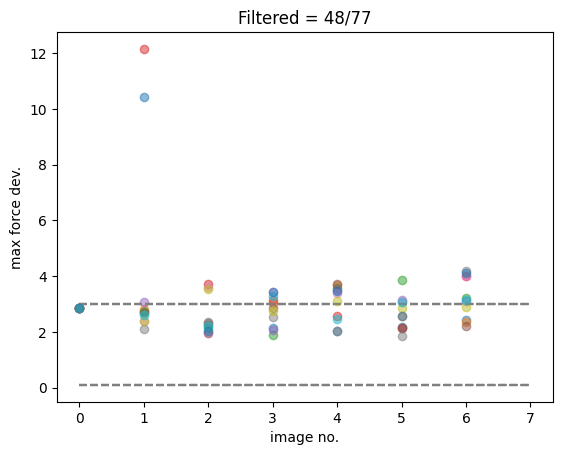

In [31]:
filtered_neb = []
upthresh = 3.0
total_neb_images = []
good_neb = []
rejected_neb = []
for j, mdev in enumerate(model_dev_i):
    total_neb_images += [len(mdev[:,-3])]
    good_neb += [[i for i,m in enumerate(mdev[:,-3]) if m <= lowthresh]]
    filtered_neb+=[[i for i,m in enumerate(mdev[:,-3]) if m > lowthresh and m <= upthresh]]
    rejected_neb+=[[i for i,m in enumerate(mdev[:,-3]) if m > upthresh]]
    plt.hlines(upthresh, 0,7,'grey',alpha=0.5,linestyles='--')
    plt.hlines(lowthresh, 0,7,'grey',alpha=0.5,linestyles='--')
    plt.plot(mdev[:,-3],'o',alpha=0.5,label=f'rxn_{j}')
plt.title(f'Filtered = {len(sum(filtered_neb,[]))}/{sum(total_neb_images)}')
# plt.legend(frameon=False)
plt.xlabel('image no.')
plt.ylabel('max force dev.')
# plt.xlim(-5,150)
# plt.ylim(-0.5,11)
# plt.savefig('maxforcedev.png',dpi=600)
config_number = []

In [32]:
print(f'Filtered = {len(sum(filtered_neb,[]))}/{sum(total_neb_images)}')
# config_number
# just a list of lists to find the structures that we have filtered out. 
for rxn in coord_list:
    count = 0
    config_i = []
    for dccomb in rxn:
        config_i += [list(np.arange(count, count+len(dccomb)))]
        count += len(dccomb)
    config_number += [config_i]

Filtered = 48/77


In [34]:
# filtered_neb
# sampled

In [45]:
# Function that replaces nth line with a replacement_string. Is used for INCAR
# replacing MAGMOM=0 with MAGMOM=NIONS*0
def replace_nth_line(file_path, n, replacement_string):
    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Check if the specified line number is valid
    if 1 <= n <= len(lines):
        # Replace the nth line with the new string
        lines[n] = replacement_string + '\n'
        
        os.system(f'mv {file_path} {file_path}.bk')
        
        # Write the modified content back to the file
        with open(file_path, 'w') as file:
            file.writelines(lines)
        print(f"Successfully replaced line {n} with: {replacement_string}")
    else:
        print(f"Invalid line number: {n}. The file has {len(lines)} lines.")
        
def create_potcar(pos, qm_method, fp_path):
#     poscar = sys.argv[1]
#     qm_method = sys.argv[2] #eg. potpaw_PBE|
    potpath=lambda q,x:f'/ihome/crc/install/intel-2017.1.132/intel-mpi-2017.1.132/vasp/potcars/{q}/{x}/POTCAR'
#     pos=read(poscar)
    sym=pos.get_chemical_symbols()
    sym_un=list(dict.fromkeys(sym))
    if 'POTCAR' in os.listdir(fp_path):
        os.system(f'rm {fp_path}/POTCAR')
    for s in sym_un:
        os.system(f'cat {potpath(qm_method,s)} >> {fp_path}/POTCAR')

In [46]:
# totalatoms_cmd = 'awk \'NR==7{ print; }\''

# preparing jobs for relabeling - write this part
for i, rxn in enumerate(filtered_neb):
    ci = config_number[i]
    count = 0
    for f in filtered_neb[i]:
        print(f)
        rxn_dir = f'{relabel_dir}/neb.{str(i).zfill(2)}'
        atom = read(f'{sampled[i]}',index=f)
        if f'neb.{str(i).zfill(2)}' not in os.listdir(relabel_dir):
            os.mkdir(rxn_dir)
        job_c = f'{rxn_dir}/{str(count).zfill(4)}'
        if f'{str(count).zfill(4)}' not in os.listdir(rxn_dir):
            os.mkdir(job_c)
        write(f'{job_c}/POSCAR', atom, sort=True)
        os.system(f'cp {input_path}/INCAR.sp {job_c}/INCAR')
        os.system(f'cp {input_path}/job.slurm {job_c}/job.slurm')
        atoms = read(f'{job_c}/POSCAR')
        create_potcar(atoms, 'potpaw_PBE', job_c)
        count += 1
        print(sampled[i], "coord: ", f)

#                     break
#             for ri, row in enumerate(ci):
#                 if f in row:
#                     rj = row.index(f)
                    
#                     rxn_dir = f'{relabel_dir}/neb.{str(i).zfill(2)}'
#                     if f'neb.{str(i).zfill(2)}' not in os.listdir(relabel_dir):
#                         os.mkdir(rxn_dir)
#                     job_c = f'{rxn_dir}/{str(count).zfill(4)}'
#                     if f'{str(count).zfill(4)}' not in os.listdir(rxn_dir):
#                         os.mkdir(job_c)
#                     atom = read(f'{}')
#                     atom = read(f'{sampled[i][ri]}/opt_converged_000_ase.xyz', index=rj)


# #                     totalatoms = len(atom.get_positions())
#                     magmom = f'MAGMOM={totalatoms}*0'
#                     atom.set_cell([10,10,10])
#                     write(f'{job_c}/POSCAR', atom)
#                     os.system(f'cp {input_path}/INCAR {job_c}/INCAR')
#                     replace_nth_line(f'{job_c}/INCAR', 4, magmom)
#                     os.system(f'cp {input_path}/job.slurm {job_c}/job.slurm')
#                     os.system(f'cp {input_path}/POTCAR {job_c}/POTCAR')
#                     count += 1
                    
#                     print(sampled[i][ri], "coord: ", rj)
#                     break

0
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  0
1
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  1
2
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  2
3
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  3
4
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  4
5
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  5
6
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_000.traj coord:  6
0
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/reaction/test/neb/final_neb/neb_001.traj coord:  0
1
/bgfs/

In [39]:
# atom.get_chemical_symbols()

## Scratch work

In [66]:
import numpy as np
from ase.io import read, write
from scipy.spatial.distance import cdist
from ase.geometry import get_distances

def reorder_atoms(a_atoms, b_atoms):
    # Extract atomic symbols and positions
    a_symbols = a_atoms.get_chemical_symbols()
    b_symbols = b_atoms.get_chemical_symbols()
    a_positions = a_atoms.get_positions()
    b_positions = b_atoms.get_positions()
#     print(a_atoms)

    # Calculate pairwise distances between atoms in A and B
#     distances = cdist(a_positions, b_positions)
#     print(distances.shape)
    distances = get_distances(a_positions, b_positions, cell=a_atoms.cell, pbc=False)[1]
    print(distances)
#     print(distances[0].shape, distances[1].shape)

    # Create a mapping from indices of atoms in B to indices of atoms in A
    atom_mapping = []
    for i in range(len(a_atoms)):
        # Find the closest unmatched atom in B to the ith atom in A
        min_dist_idx = np.argmin(distances)
        min_dist_idx_a, min_dist_idx_b = np.unravel_index(min_dist_idx, distances.shape)
        # Ensure that the atoms have the same species
        if a_symbols[min_dist_idx_a] == b_symbols[min_dist_idx_b]:
            atom_mapping.append((min_dist_idx_a, min_dist_idx_b))
        distances[min_dist_idx_a, :] = np.inf
        distances[:, min_dist_idx_b] = np.inf

    # Rearrange atoms in B based on the mapping
    b_reordered_positions = [b_positions[idx_b] for _, idx_b in sorted(atom_mapping, key=lambda x: x[0])]
    b_reordered_symbols = [b_symbols[idx_b] for _, idx_b in sorted(atom_mapping, key=lambda x: x[0])]
    b_reordered = Atoms(symbols=b_reordered_symbols, positions=b_reordered_positions)
    print(b_reordered_symbols)
    print(b_reordered_positions)
    return b_reordered

# Read A.xyz and B.xyz files
a_atoms = read('n2-h2.xyz')
b_atoms = read('n2-h2_B.xyz')

# Reorder atoms in B to match A
b_reordered = reorder_atoms(a_atoms, b_atoms)

# Write the reordered structure to a new XYZ file
# write('B_reordered.xyz', b_reordered)


[[0.02       3.26173459 3.23340325 1.23285117]
 [1.25972899 3.2391116  3.23746663 0.025     ]
 [3.24082164 0.70800551 0.0726439  3.26931531]
 [3.26209205 0.         0.75293421 3.24366518]]
['N', 'N', 'H', 'H']
[array([-3.16764,  0.73976, -0.77887]), array([-2.58309, -0.2656 , -1.23416]), array([-0.9    ,  0.29052,  1.48574]), array([-0.44728,  0.67146,  1.02008])]


In [ ]:
# posCr = ratm.get_positions()[whereCr]
# print(posCr)
for i, p in enumerate(prods):
    patm = read(p)
    del patm.constraints
    del ratm.constraints
    p_reordered = reorder_atoms(ratm, patm)
    p_reordered.set_cell(patm.cell)
    p_reordered.set_pbc(True)
    write(f'{final_rearranged_path}/{prods_i[i]}', p_reordered)
    break

In [24]:
import numpy as np
from ase.io import read, write
from scipy.spatial.distance import cdist

def reorder_atoms(a_atoms, b_atoms):
    # Extract atomic symbols and positions
    a_symbols = a_atoms.get_chemical_symbols()
    b_symbols = b_atoms.get_chemical_symbols()
    a_positions = a_atoms.get_positions()
    b_positions = b_atoms.get_positions()

    # Calculate pairwise distances between atoms in A and B
    distances = cdist(a_positions, b_positions)

    # Create a mapping from indices of atoms in B to indices of atoms in A
    atom_mapping = []
    for i in range(len(a_atoms)):
        # Find the closest unmatched atom in B to the ith atom in A
        min_dist_idx = np.argmin(distances)
        min_dist_idx_a, min_dist_idx_b = np.unravel_index(min_dist_idx, distances.shape)
        # Ensure that the atoms have the same species
        if a_symbols[min_dist_idx_a] == b_symbols[min_dist_idx_b]:
            atom_mapping.append((min_dist_idx_a, min_dist_idx_b))
        distances[min_dist_idx_a, :] = np.inf
        distances[:, min_dist_idx_b] = np.inf

    # Sort atom_mapping based on the index in A
    atom_mapping.sort()

    # Rearrange atoms in B based on the mapping
    b_reordered_positions = [b_positions[idx_b] for _, idx_b in atom_mapping]
    b_reordered_symbols = [b_symbols[idx_b] for _, idx_b in atom_mapping]
    b_reordered = Atoms(symbols=b_reordered_symbols, positions=b_reordered_positions)
    print(b_reordered_symbols)
    print(b_reordered_positions)
    return b_reordered

# Read A.xyz and B.xyz files
a_atoms = read('n2-h2.xyz')
b_atoms = read('n2-h2_B.xyz')

# Reorder atoms in B to match A
b_reordered = reorder_atoms(a_atoms, b_atoms)

# Write the reordered structure to a new XYZ file
# write('B_reordered.xyz', b_reordered)


['N', 'N', 'H', 'H']
[array([-3.16764,  0.73976, -0.77887]), array([-2.58309, -0.2656 , -1.23416]), array([-0.9    ,  0.29052,  1.48574]), array([-0.44728,  0.67146,  1.02008])]


In [2]:
# purpose of this python notebook is to make use of catkit to generate intermediates
a = read('/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/ethane.db')

In [17]:
db_name = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/ethane.db'
with ReactionNetwork(db_name=db_name) as rn:
    # Run a molecule search
    rn.molecule_search(
        element_pool={'C': 2, 'H': 6},
        multiple_bond_search=False)

    
#     a = rn.load_3d_structures(0)

# print('Process completed in {:.1f}s'.format(time.time() - start))

In [18]:
molecules

<module 'catkit.gen.molecules' from '/ihome/kjohnson/ska31/.local/lib/python3.9/site-packages/catkit/gen/molecules.py'>

In [5]:
# rn = ReactionNetwork(db_name)
# rn.molecule_search(
#     element_pool={'C': 2, 'H': 6},
#     multiple_bond_search=False)

In [49]:
s = molecules.get_topologies('HCHCH')
a = molecules.get_3D_positions(s[0])
a

Gratoms(symbols='C2H3', pbc=False, cell=[1.0, 1.0, 1.0])

In [52]:
a.get_distances(0,1), a.get_chemical_symbols()

(array([1.52]), ['C', 'C', 'H', 'H', 'H'])

In [42]:
with ReactionNetwork(db_name=db_name) as rn:

    # Run a molecule search
    rn.molecule_search(
        element_pool={'C': 2, 'H': 6},
        multiple_bond_search=False)

with ReactionNetwork(db_name=db_name) as rn:
    # Substitution pathway search is expensive!
    rn.path_search(
        reconfiguration=False,
        substitution=False)

#     rn.plot_reaction_network(file_name='reaction-network.png')

with ReactionNetwork(db_name=db_name) as rn:
    molecules_list = rn.load_molecules()
    pathways_list = rn.load_pathways()

# names = np.empty(len(molecules_list) + 1, dtype='a5')

# for k, v in molecules_list.items():
#     atn = nx.get_node_attributes(v.graph, 'number')

#     # These are not always unique identifiers
#     hill = formula_hill(list(atn.values()))
#     names[k] = hill

# print('|Reactants|Products|')
# print('|-')
# for path in pathways:
#     print('|{} + {} | {} |'.format(
#         names[path][0].decode("utf-8"),
#         names[path][1].decode("utf-8"),
#         names[path][3].decode("utf-8")))

In [70]:
all_symbols = []
for k, v in molecules_list.items():
    all_symbols += [v.get_chemical_formula()]

In [114]:
# unique_symbols = list(set(all_symbols))
# tops = [molecules.get_topologies(x) for x in unique_symbols]
# molecules.get_3D_positions(tops[4])
# , molecules.get_3D_positions(tops[4][1]).get_positions()

In [113]:
save_path = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/molecule/intermediates'
for s, t in zip(unique_symbols, tops):
    grat = [molecules.get_3D_positions(x) for x in t]
    for i, g in enumerate(grat):
        write(f'{save_path}/{s}.{str(i).zfill(2)}.xyz', g)

In [73]:
molecules.get_topologies(all_symbols[0])

[Gratoms(symbols='H', pbc=False)]

In [25]:
with ReactionNetwork(db_name=db_name) as rn:

    # Run a molecule search
    rn.molecule_search(
        element_pool={'C': 2, 'H': 6},
        multiple_bond_search=False)
    rn.save_3d_structure

In [27]:
b = connect(db_name)

In [42]:
# dir(b)